# Import Libraries

In [1]:
# Import necessary libraries for data processing, model training, and evaluation.
import logging
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split  

# Logging setup

In [2]:
# Logging setup to capture model performance and debugging messages
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger()

# Load and Preprocess Dataset

In [3]:
# Loading and validating the dataset. Ensure the dataset is in the expected format.logger.info("Loading dataset...")
logger.info("Loading dataset...")

2024-11-30 13:27:38,171 - INFO - Loading dataset...


In [4]:
try:
    with open("datasetFix.json", "r", encoding="utf-8") as file:
        data = json.load(file)
    logger.info("Dataset successfully loaded.")
except FileNotFoundError:
    logger.error("Dataset file not found. Please check the file path.")
    exit()
except json.JSONDecodeError:
    logger.error("Dataset file is not a valid JSON. Please check the file format.")
    exit()


2024-11-30 13:27:38,177 - INFO - Dataset successfully loaded.


In [5]:
# Convert JSON to DataFrame
with open("datasetFix.json", "r", encoding="utf-8") as file:
    data = json.load(file)

df = pd.DataFrame(data)

In [6]:
print(df.head())

                 title                                        description  \
0          Tari Landek  Tarian tradisional Karo yang dilakukan dengan ...   
1      Tari Piso Surit  Tarian yang menggambarkan suara burung Piso Su...   
2  Tari Guro-Guro Aron  Tarian yang biasanya ditampilkan pada upacara ...   
3            Ulos Karo  Kain tenun khas Karo yang memiliki motif unik ...   
4        Anyaman Rotan  Kerajinan tangan dari rotan yang dibuat menjad...   

             category languageType mediaURL  
0    Tarian Nusantara        Medan     None  
1    Tarian Nusantara        Medan     None  
2    Tarian Nusantara        Medan     None  
3  Seni dan Kerajinan        Medan     None  
4  Seni dan Kerajinan        Medan     None  


In [7]:
# Validate dataset (check for missing columns)
required_columns = ["description", "category"]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    logger.error(f"Dataset is missing required columns: {missing_columns}")
    exit()
logger.info("All required columns are present in the dataset.")


2024-11-30 13:27:38,226 - INFO - All required columns are present in the dataset.


In [8]:
# Check for missing values
logger.info("Checking and dropping missing values...")
df = df.dropna(subset=required_columns)
logger.info(f"Dataset size after cleaning: {len(df)} rows.")

2024-11-30 13:27:38,244 - INFO - Checking and dropping missing values...
2024-11-30 13:27:38,244 - INFO - Dataset size after cleaning: 1095 rows.


# Tokenizing and Label Encoding

In [9]:
# Tokenizing the text and encoding labels
logger.info("Tokenizing text...")
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df["description"])
X_seq = pad_sequences(tokenizer.texts_to_sequences(df["description"]), maxlen=100)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["category"])

2024-11-30 13:27:38,254 - INFO - Tokenizing text...


In [10]:
# Split dataset into train, validation, and test sets
logger.info("Splitting dataset into train, validation, and test sets...")
X_seq = torch.tensor(X_seq, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

dataset = torch.utils.data.TensorDataset(X_seq, y)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

2024-11-30 13:27:38,289 - INFO - Splitting dataset into train, validation, and test sets...


# LSTM Model Definition

In [11]:
# LSTM model definition
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        x = self.dropout(hidden[-1])
        return self.fc(x)

# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered at validation loss: {val_loss:.4f}")
        return self.early_stop

# Hyperparameter tuning and early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = 5000
output_dim = len(label_encoder.classes_)
embedding_dim = 100
hidden_dim = 128
dropout = 0.5

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=2, verbose=True)

for epoch in range(10):  # Limit to 10 epochs
    model.train()  # Set model to training mode
    epoch_loss = 0
    correct_predictions = 0
    total_samples = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == y_batch).sum().item()
        total_samples += y_batch.size(0)

    epoch_accuracy = correct_predictions / total_samples
    val_loss = epoch_loss / len(train_loader)

    # Log training stats
    logger.info(f"Epoch {epoch+1} - Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Early stopping check
    if early_stopping(val_loss, model):
        logger.info(f"Early stopping triggered after epoch {epoch+1}.")
        break

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == y_val).sum().item()
            total_samples += y_val.size(0)

        val_accuracy = correct_predictions / total_samples
        logger.info(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")


2024-11-30 13:27:41,339 - INFO - Epoch 1 - Training Loss: 28.2742, Accuracy: 0.7115
2024-11-30 13:27:41,373 - INFO - Validation Loss: 0.7505, Validation Accuracy: 0.7195
2024-11-30 13:27:42,029 - INFO - Epoch 2 - Training Loss: 14.0571, Accuracy: 0.8081
2024-11-30 13:27:42,076 - INFO - Validation Loss: 0.6853, Validation Accuracy: 0.7866
2024-11-30 13:27:42,656 - INFO - Epoch 3 - Training Loss: 12.9559, Accuracy: 0.8446
2024-11-30 13:27:42,687 - INFO - Validation Loss: 0.6592, Validation Accuracy: 0.7988
2024-11-30 13:27:43,282 - INFO - Epoch 4 - Training Loss: 11.8737, Accuracy: 0.8629
2024-11-30 13:27:43,322 - INFO - Validation Loss: 0.6275, Validation Accuracy: 0.8171
2024-11-30 13:27:43,924 - INFO - Epoch 5 - Training Loss: 10.6089, Accuracy: 0.8734
2024-11-30 13:27:43,955 - INFO - Validation Loss: 0.5953, Validation Accuracy: 0.8110
2024-11-30 13:27:44,551 - INFO - Epoch 6 - Training Loss: 9.3672, Accuracy: 0.8930
2024-11-30 13:27:44,583 - INFO - Validation Loss: 0.5676, Validatio

# Visualize Data (Bar chart, Word Cloud, Treemap, Network Graph)


## Bar Chart

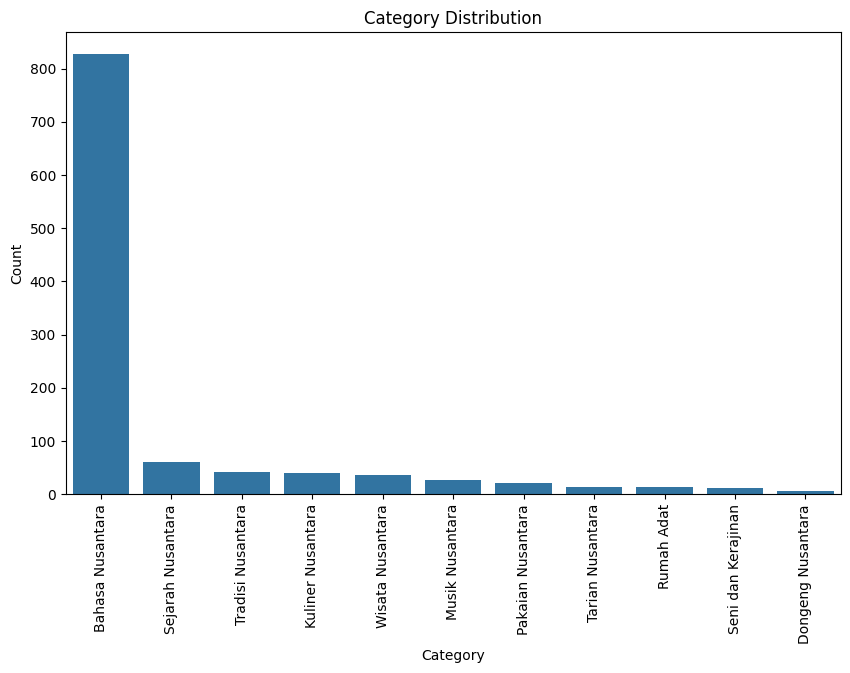

In [12]:
# Visualize category distribution using a bar chart
category_counts = df['category'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

## Word Cloud

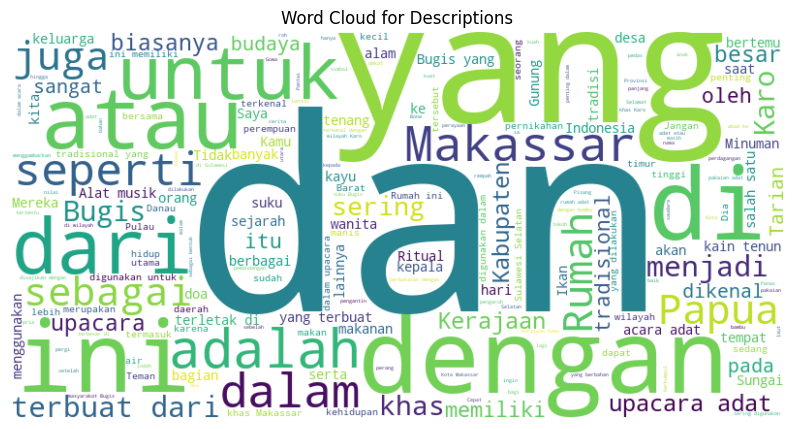

In [13]:
# Word Cloud for text data
text_data = " ".join(df["description"].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Descriptions')
plt.show()

## Treemap

In [14]:
# Treemap of category distribution using Plotly
category_counts_df = category_counts.reset_index().rename(columns={'index': 'category', 'count': 'Count'})
fig = px.treemap(category_counts_df, path=['category'], values='Count', title='Category Distribution Treemap')
fig.show()


## Network Graph

In [15]:
# Creating the Graph: Nodes = Categories, Edges = Relationships between entries with the same category
category_counts = df['category'].value_counts()  # Count the number of entries for each category
categories = category_counts.index.tolist()  # List of category names

# Create an empty graph
G = nx.Graph()
# Add nodes for each category
for category in categories:
    G.add_node(category, size=category_counts[category])  # Add category nodes with size based on entry count

# Add edges (relationships between categories based on shared category entries)
# This is an example: if entries share the same category, connect them
for idx, row in df.iterrows():
    current_category = row['category']
    # Connect categories based on entries (no duplication, just an example)
    for other_category in categories:
        if current_category != other_category:
            G.add_edge(current_category, other_category)

In [16]:
# Positioning Nodes in the Graph (using NetworkX layout)
pos = nx.spring_layout(G)  # Using the 'spring' layout for node positions

# X and Y coordinates for each node
node_x = []
node_y = []
node_text = []  # To store node labels

for node in G.nodes():
    node_x.append(pos[node][0])
    node_y.append(pos[node][1])
    node_text.append(f'{node} ({category_counts[node]} entries)')  # Label: Category name and entry count

# Edges between nodes
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_y.append(y0)
    edge_x.append(x1)
    edge_y.append(y1)

In [ ]:
# Plot data
# Adding edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=0.5, color='#888'),
    hoverinfo='none'
)

# Adding node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',  # Display text on hover
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',  # Node coloring
        size=20,
        colorbar=dict(
            thickness=15,
            title='Node Size',
            xanchor='left',
            titleside='right'
        )
    )
)

# Coloring nodes based on the number of entries in each category
node_trace.marker.color = [category_counts[node] for node in categories]  # Coloring based on entry count
node_trace.text = node_text  # Adding text to nodes

# Creating layout and displaying the graph
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Network Graph of Categories',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))

fig.show()

# Define LSTM Model

In [18]:
# Define LSTM-based model for classification
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        x = self.dropout(hidden[-1])
        return self.fc(x)

# Hyperparameter Tuning and Model Evaluation

In [19]:
# Hyperparameter tuning
logger.info("Starting hyperparameter tuning...")
learning_rates = [0.001, 0.005]
hidden_dims = [64, 128]
dropouts = [0.3, 0.5]
best_val_acc = 0
best_model_params = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = 5000
output_dim = len(label_encoder.classes_)

for lr in learning_rates:
    for hidden_dim in hidden_dims:
        for dropout in dropouts:
            logger.info(f"Testing model with lr={lr}, hidden_dim={hidden_dim}, dropout={dropout}")

            # Create LSTM model with the tested parameters
            model = LSTMClassifier(vocab_size, 128, hidden_dim, output_dim, dropout).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            for epoch in range(5):  # Keeping epochs low for tuning
                model.train()
                for X_batch, y_batch in train_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()

                # Evaluate on validation set
                model.eval()
                val_correct = 0
                val_total = 0
                with torch.no_grad():
                    for X_val, y_val in val_loader:
                        X_val, y_val = X_val.to(device), y_val.to(device)
                        outputs = model(X_val)
                        _, predicted = torch.max(outputs, 1)
                        val_correct += (predicted == y_val).sum().item()
                        val_total += y_val.size(0)

                val_acc = val_correct / val_total
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    # Save the best model parameters based on higher validation accuracy
                    best_model_params = (model.state_dict(), lr, hidden_dim, dropout)

# Display the best result
logger.info(f"Best validation accuracy: {best_val_acc}")
logger.info(f"Best model params: {best_model_params}")

# Load best model with the best parameters
if best_model_params is not None:
    # Ensure valid hidden_dim and dropout values
    hidden_dim = best_model_params[2] if best_model_params[2] > 0 else 128
    dropout = best_model_params[3] if best_model_params[3] > 0 else 0.3
    logger.info(f"Using hidden_dim={hidden_dim} and dropout={dropout} for best model.")

    # Load the model with the best parameters
    model = LSTMClassifier(vocab_size, 128, hidden_dim, output_dim, dropout).to(device)
    model.load_state_dict(best_model_params[0])  # Load the state_dict of the best model
else:
    logger.error("No valid model found during hyperparameter tuning.")

2024-11-30 13:27:49,435 - INFO - Starting hyperparameter tuning...
2024-11-30 13:27:49,435 - INFO - Testing model with lr=0.001, hidden_dim=64, dropout=0.3
2024-11-30 13:27:51,840 - INFO - Testing model with lr=0.001, hidden_dim=64, dropout=0.5
2024-11-30 13:27:54,037 - INFO - Testing model with lr=0.001, hidden_dim=128, dropout=0.3
2024-11-30 13:27:57,504 - INFO - Testing model with lr=0.001, hidden_dim=128, dropout=0.5
2024-11-30 13:28:00,828 - INFO - Testing model with lr=0.005, hidden_dim=64, dropout=0.3
2024-11-30 13:28:02,953 - INFO - Testing model with lr=0.005, hidden_dim=64, dropout=0.5
2024-11-30 13:28:05,214 - INFO - Testing model with lr=0.005, hidden_dim=128, dropout=0.3
2024-11-30 13:28:08,867 - INFO - Testing model with lr=0.005, hidden_dim=128, dropout=0.5
2024-11-30 13:28:12,221 - INFO - Best validation accuracy: 0.8536585365853658
2024-11-30 13:28:12,256 - INFO - Best model params: (OrderedDict([('embedding.weight', tensor([[ 1.1730, -2.5142, -0.1969,  ...,  1.8696, -

In [20]:
# Model Evaluation
# Evaluating the best model on test data
logger.info("Evaluating on test set...")
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

2024-11-30 13:28:12,269 - INFO - Evaluating on test set...


In [ ]:
logger.info("\nClassification Report:\n" + classification_report(y_true, y_pred,
                                                              target_names=label_encoder.classes_[:11],
                                                              labels=label_encoder.transform(label_encoder.classes_[:11])))

c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

2024-11-30 13:28:12,325 - INFO - 
Classification Report:
                    precision    recall  f1-score   support

  Bahasa Nusantara       0.98      1.00      

2024-11-30 13:28:12,340 - INFO - Generating confusion matrix...


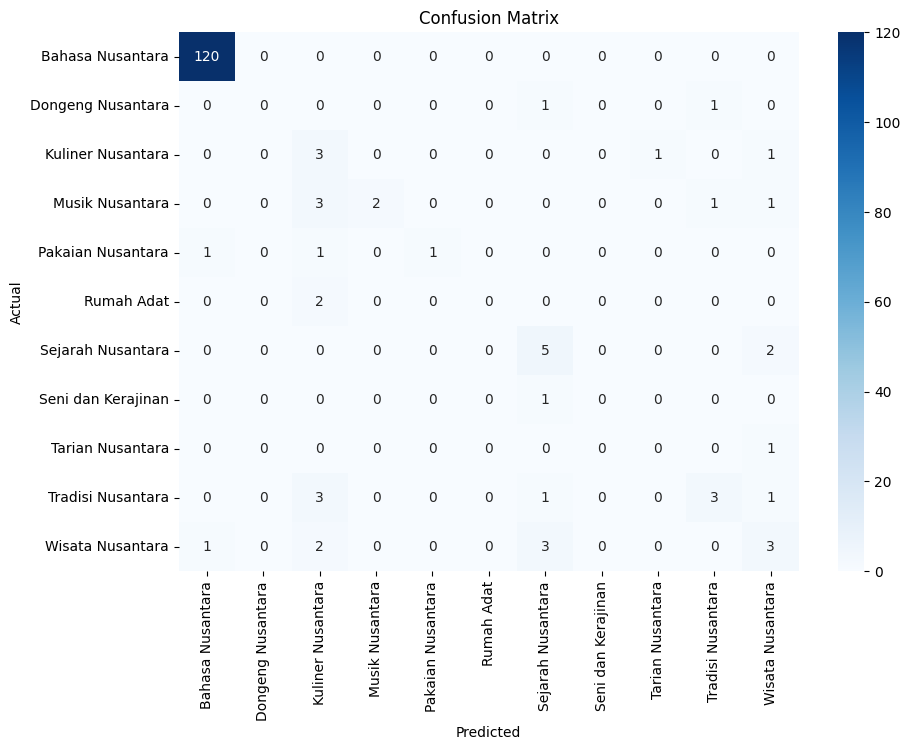

In [22]:
# Confusion Matrix
logger.info("Generating confusion matrix...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve

2024-11-30 13:28:12,725 - INFO - Generating ROC curve...


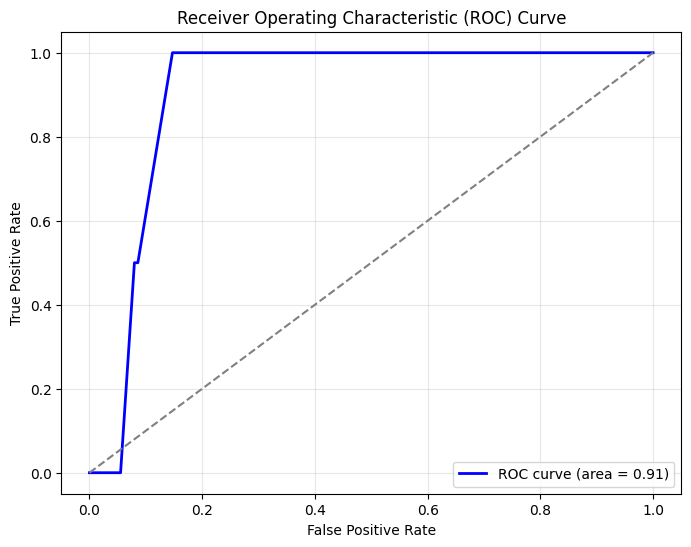

In [23]:
logger.info("Generating ROC curve...")

# Ensure y_pred contains probabilities for the positive class (e.g., the output of a model's sigmoid or softmax)
fpr, tpr, thresholds = roc_curve(y_true, np.array(y_pred), pos_label=1)  # Make sure y_pred is probabilities
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})", color="blue", lw=2)
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", lw=1.5)  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [24]:
# Save the model
logger.info("Saving the best model...")
torch.save(model.state_dict(), "lstm_model.pt")
logger.info("Model saved as lstm_model.pt.")

2024-11-30 13:28:12,857 - INFO - Saving the best model...
2024-11-30 13:28:12,866 - INFO - Model saved as lstm_model.pt.


# TF-IDF Vectorization

In [25]:
logger.info(f"Train dataset size: {len(train_dataset)}")
logger.info(f"Validation dataset size: {len(val_dataset)}")
logger.info(f"Test dataset size: {len(test_dataset)}")

2024-11-30 13:28:12,874 - INFO - Train dataset size: 766
2024-11-30 13:28:12,882 - INFO - Validation dataset size: 164
2024-11-30 13:28:12,882 - INFO - Test dataset size: 165


In [26]:
for batch in train_loader:
    X_batch, y_batch = batch
    logger.info(f"First batch X: {X_batch.shape}, y: {y_batch.shape}")
    break

2024-11-30 13:28:12,889 - INFO - First batch X: torch.Size([32, 100]), y: torch.Size([32])


In [27]:
# Combine title and description into a single text column
df['text'] = df['title'] + " " + df['description']

# Extract 'text' as X (features) and 'category' as y (labels)
X = df['text'].values
y = df['category'].values

# If the categories are still in text, convert them to numerical labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert categories to numbers

# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% for training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split remaining 50% into validation and test

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform on X_train
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform on X_val and X_test using the same features as X_train
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# Convert the results to tensors
X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_val_tfidf = torch.tensor(X_val_tfidf.toarray(), dtype=torch.float32)
X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Create TensorDataset for train, validation, and test sets
train_dataset = TensorDataset(X_train_tfidf, torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(X_val_tfidf, torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_tfidf, torch.tensor(y_test, dtype=torch.long))

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
# Logger Setup
logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)

# Combine 'title' and 'description' columns into one 'text' column
df['text'] = df['title'] + " " + df['description']

# Take 'text' column as X (features) and 'category' column as y (labels)
X = df['text'].values
y = df['category'].values

# Split the dataset into train and test with stratification based on category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize LabelEncoder to convert category labels into numeric labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Get the original categories from the encoded labels
categories = label_encoder.classes_

# TF-IDF Vectorization: Convert text into numerical representation
logger.info("Vectorizing text using TF-IDF...")
tfidf = TfidfVectorizer(max_features=5000)  # Limit the number of features to 5000
X_train_tfidf = tfidf.fit_transform(X_train)  # Fit on train data and transform
X_test_tfidf = tfidf.transform(X_test)        # Only transform the test data

# Save the TF-IDF Vectorizer to a file
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
logger.info("TF-IDF Vectorizer saved.")

# Build and train Logistic Regression model
model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
model.fit(X_train_tfidf, y_train_encoded)

# Make predictions on the test data
y_pred = model.predict(X_test_tfidf)

# Display classification report
logger.info("Generating classification report...")
report = classification_report(y_test_encoded, y_pred, target_names=categories)
logger.info("\nClassification Report:")
print(report)

2024-11-30 13:28:12,958 - INFO - Vectorizing text using TF-IDF...


2024-11-30 13:28:13,008 - INFO - TF-IDF Vectorizer saved.
2024-11-30 13:28:13,112 - INFO - Generating classification report...
c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

2024-11-30 13:28:13,129 - INFO - 
Cl

                    precision    recall  f1-score   support

  Bahasa Nusantara       0.82      1.00      0.90       165
 Dongeng Nusantara       0.00      0.00      0.00         1
 Kuliner Nusantara       1.00      0.38      0.55         8
   Musik Nusantara       0.67      0.40      0.50         5
 Pakaian Nusantara       1.00      0.75      0.86         4
        Rumah Adat       1.00      0.33      0.50         3
 Sejarah Nusantara       1.00      0.50      0.67        12
Seni dan Kerajinan       0.00      0.00      0.00         3
  Tarian Nusantara       0.00      0.00      0.00         3
 Tradisi Nusantara       0.50      0.12      0.20         8
  Wisata Nusantara       0.00      0.00      0.00         7

          accuracy                           0.83       219
         macro avg       0.54      0.32      0.38       219
      weighted avg       0.78      0.83      0.78       219



In [29]:
logger.info("Vectorizing text using TF-IDF...")
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

2024-11-30 13:28:13,144 - INFO - Vectorizing text using TF-IDF...


In [30]:
# Save TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
logger.info("TF-IDF Vectorizer saved.")

2024-11-30 13:28:13,225 - INFO - TF-IDF Vectorizer saved.


# Logistic Regression Model with Hyperparameter Tuning

In [31]:
# Performing hyperparameter tuning for Logistic Regression...
logger.info("Performing hyperparameter tuning for Logistic Regression...")
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200, 500]
}

grid_search = GridSearchCV(
    LogisticRegression(multi_class='multinomial'),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train_tfidf, y_train)

best_model = grid_search.best_estimator_
logger.info(f"Best model parameters: {grid_search.best_params_}")

2024-11-30 13:28:13,242 - INFO - Performing hyperparameter tuning for Logistic Regression...
c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *a

In [32]:
# Final Evaluation on Test Set
logger.info("Evaluating on test set...")
y_test_pred = best_model.predict(X_test_tfidf)
test_report = classification_report(y_test, y_test_pred)
logger.info("\nTest Set Classification Report:\n" + test_report)

2024-11-30 13:28:18,271 - INFO - Evaluating on test set...
c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

2024-11-30 13:28:18,281 - INFO - 
Test Set Classification Report:
                    precision    recal

In [33]:
# Save the trained model
joblib.dump(best_model, "logistic_regression_model.pkl")
logger.info("Trained model saved as logistic_regression_model.pkl.")

2024-11-30 13:28:18,297 - INFO - Trained model saved as logistic_regression_model.pkl.


# Split into training and testing sets


In [34]:
print("Splitting into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Splitting into training and testing sets...


# Vectorize text data using TF-IDF


In [35]:
print("Vectorizing text using TF-IDF...")
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Vectorizing text using TF-IDF...


# Train a Logistic Regression model


In [36]:
print("Training Logistic Regression model...")
model = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
model.fit(X_train_tfidf, y_train)

Training Logistic Regression model...


LogisticRegression(max_iter=1000, multi_class='multinomial')

# Evaluate the model


In [37]:
print("Evaluating model performance...")
y_pred = model.predict(X_test_tfidf)

Evaluating model performance...


In [38]:
# Display the classification report
report = classification_report(y_test, y_pred, target_names=categories)
print("\nClassification Report:")
print(report)


Classification Report:
                    precision    recall  f1-score   support

  Bahasa Nusantara       0.82      1.00      0.90       165
 Dongeng Nusantara       0.00      0.00      0.00         1
 Kuliner Nusantara       1.00      0.38      0.55         8
   Musik Nusantara       0.67      0.40      0.50         5
 Pakaian Nusantara       1.00      0.75      0.86         4
        Rumah Adat       1.00      0.33      0.50         3
 Sejarah Nusantara       1.00      0.50      0.67        12
Seni dan Kerajinan       0.00      0.00      0.00         3
  Tarian Nusantara       0.00      0.00      0.00         3
 Tradisi Nusantara       0.50      0.12      0.20         8
  Wisata Nusantara       0.00      0.00      0.00         7

          accuracy                           0.83       219
         macro avg       0.54      0.32      0.38       219
      weighted avg       0.78      0.83      0.78       219



c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [39]:
# Print the length of actual and predicted data
print(len(y_test))   # Number of actual data points
print(len(y_pred))   # Number of predicted data points

219
219


In [40]:
# Check the unique labels in y_test and y_pred
unique_labels = sorted(set(y_test) | set(y_pred))

# Generate the confusion matrix with valid labels
print("Generating confusion matrix...")
conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)

# Display the confusion matrix
print(conf_matrix)

Generating confusion matrix...
[[165   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0]
 [  5   0   3   0   0   0   0   0   0   0   0]
 [  3   0   0   2   0   0   0   0   0   0   0]
 [  1   0   0   0   3   0   0   0   0   0   0]
 [  2   0   0   0   0   1   0   0   0   0   0]
 [  6   0   0   0   0   0   6   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   1   0   0   0   0   0   1   0]
 [  7   0   0   0   0   0   0   0   0   1   0]
 [  7   0   0   0   0   0   0   0   0   0   0]]


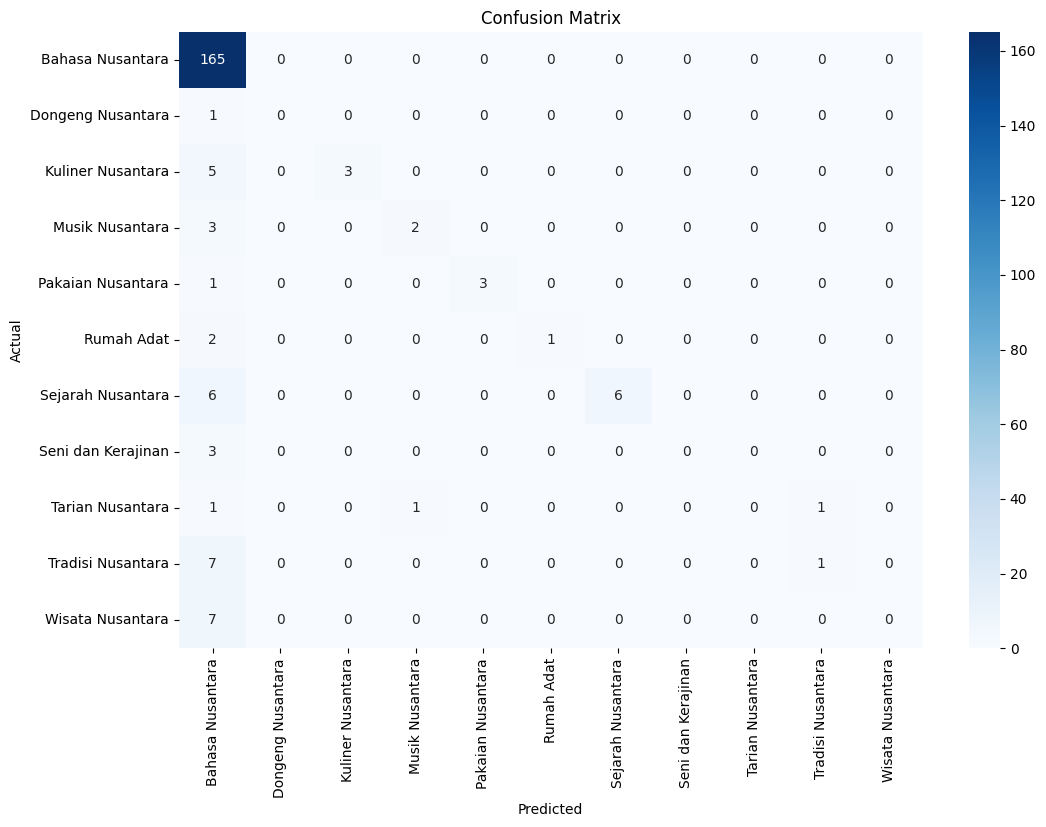

In [41]:
# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    xticklabels=categories,
    yticklabels=categories,
    cmap="Blues",
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the processed dataset, model, and vectorizer

In [42]:
print("Saving processed dataset, model, and vectorizer...")
df.to_csv("processed_dataset.csv", index=False)
joblib.dump(model, "cultural_classifier_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("All files have been saved successfully.")


Saving processed dataset, model, and vectorizer...
All files have been saved successfully.


In [43]:
# Summary of steps
print("\n--- SUMMARY ---")
print("1. Dataset loaded and processed.")
print(f"2. Found {len(categories)} categories.")
print("3. Model trained using Logistic Regression.")
print("4. Model evaluation completed with classification report and confusion matrix.")
print("5. Files saved: 'processed_dataset.csv', 'cultural_classifier_model.pkl', 'tfidf_vectorizer.pkl'.")


--- SUMMARY ---
1. Dataset loaded and processed.
2. Found 11 categories.
3. Model trained using Logistic Regression.
4. Model evaluation completed with classification report and confusion matrix.
5. Files saved: 'processed_dataset.csv', 'cultural_classifier_model.pkl', 'tfidf_vectorizer.pkl'.


# Logging dan Monitoring


In [44]:
# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger()

# Replace all print statements with logger
logger.info("Loading dataset...")

2024-11-30 13:28:18,990 - INFO - Loading dataset...


# Validate required fields

In [45]:
# Columns that must be in the dataset
required_columns = ["description", "category"]

# Validate columns in the DataFrame
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    logger.error(f"Dataset is missing required columns: {missing_columns}")
    exit()
else:
    logger.info("All required columns are present in the dataset.")

2024-11-30 13:28:18,998 - INFO - All required columns are present in the dataset.


In [46]:
logger.info("Splitting dataset into train, validation, and test sets...")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

logger.info(f"Train set: {len(X_train)} samples, Validation set: {len(X_val)} samples, Test set: {len(X_test)} samples")

logger.info(f"Features in X_train: {X_train_tfidf.shape[1]}")
logger.info(f"Features in X_val: {X_val_tfidf.shape[1]}")
logger.info(f"Features in X_test: {X_test_tfidf.shape[1]}")

if X_train_tfidf.shape[1] != X_val_tfidf.shape[1] or X_train_tfidf.shape[1] != X_test_tfidf.shape[1]:
    logger.error("Feature mismatch detected. Ensure TF-IDF vectorizer is used consistently.")
    exit()


2024-11-30 13:28:19,006 - INFO - Splitting dataset into train, validation, and test sets...
2024-11-30 13:28:19,021 - INFO - Train set: 766 samples, Validation set: 164 samples, Test set: 165 samples
2024-11-30 13:28:19,022 - INFO - Features in X_train: 2518
2024-11-30 13:28:19,022 - INFO - Features in X_val: 2518
2024-11-30 13:28:19,022 - INFO - Features in X_test: 2518


In [47]:
tfidf = TfidfVectorizer(max_features=5000)